# **Chipotle Customer Segmentation: A K-means Clustering Approach to Survey Analysis**
Kyle Pelham, kyleplhm@gmail.com

# Introduction

In this notebook, we're going to have some fun exploring customer data from a 2016 survey of Chipotle customers in a particular city. Using principle component analysis (PCA) and k-means clustering, we'll discover unique customer groups based on their survey responses. Then, we'll come up with cool marketing ideas to help Chipotle connect with their customers even better and keep them coming back for more delicious burritos and bowls!

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading in & Cleaning the Survey Data

After reading in the data, completely blank rows and columns are filtered out. This is likely due to formatting issues when the survey data was exported.

Using the info() function confirms that columns are already assigned to the proper classes. However, it also reveals that there are multiple columns with null values.

In [3]:
# Read in Chipotle survey data 
df = pd.read_csv('Data\chipotle survey.csv')

# Drop rows and columns that are blank due to survey formatting issues
df = df.iloc[0:357,0:25]

# Preview data with info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   top1                  357 non-null    object 
 1   wom                   357 non-null    float64
 2   sm                    357 non-null    float64
 3   walk                  357 non-null    float64
 4   billboard             357 non-null    float64
 5   patronage             357 non-null    float64
 6   importantconvenience  338 non-null    float64
 7   importantvariety      333 non-null    float64
 8   importantprice        334 non-null    float64
 9   importanthealthy      335 non-null    float64
 10  importanttaste        332 non-null    float64
 11  importantambience     335 non-null    float64
 12  chipotleconvenient    334 non-null    float64
 13  chipotlevariety       333 non-null    float64
 14  chipotleprice         336 non-null    float64
 15  chipotlehealthy       3

Visualizing the null values also reveals that there are many observations where the survey was not completed entirely. Since, we are using K-means clustering, these values need to be imputed or the rows must be dropped all together. To get more distinct clusters, it makes most sense to just drop the rows with null values. Using imputation may impact the usefulness of the clusters.

<Axes: >

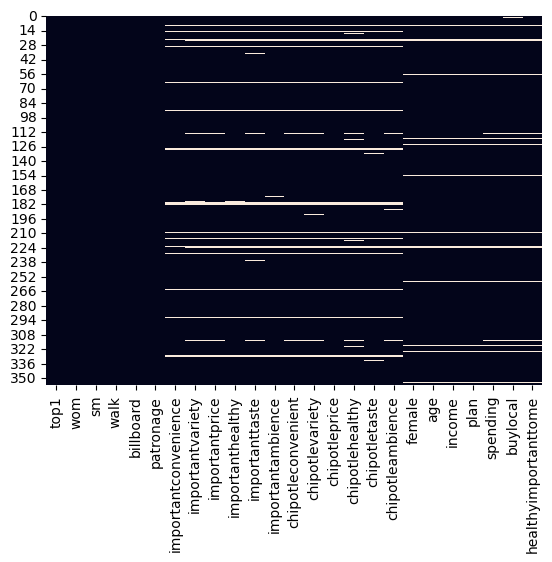

In [4]:
# Create heatmap to visualize NA values in each column
sns.heatmap(df.isna(), cbar=False)

After dropping, there are 313 of the original 357 rows remaining. This should not impact the ability to form clusters.

In [5]:
# Drop rows with NA values because k-means clustering cannot handle NA values and imputing them could skew the data
df.dropna(inplace=True)

# Shape of cleaned data after dropping NA values
df.shape

(313, 25)

The first question of the survey asks respondents to list their most visited quick-service restaurant in the last six-months. This resulted in multiple spellings and variations of restaurant names.

In [6]:
# Print unique values in each column for top1 column
pd.Series(df['top1'].unique()).sort_values()

9               Applebees
7                   Arbys
20            Chick fil a
15             Chick fila
3             Chick-Fil-A
8             Chick-fil-a
37                Chipole
4                Chipolte
1                Chipotle
18          El Pollo Loco
13                 Eppies
0                In-n-out
12    In-n-out Kebob Shop
31           Jason's Deli
33            Jasons Deli
5                     KFC
25             MacDonalds
6               McDonalds
36              Mcdonalds
11                Outback
2                  Panera
19           Panera bread
30              Pizza Hut
14          Pizza express
17              Starbucks
21                Sub Way
28                 Subway
27              Taco Bell
29             The Market
24                Wendy's
22                 Wendys
23                  arbys
32            burger king
26              chickfila
16             chik-fil-a
34              mcdonalds
10                 panera
35           panera bread
dtype: objec

Using regular expressions and string operators, the different spellings can be replaced with the correct spelling and formatting.

In [7]:
# Replace all values in top1 column that contain variations of restaurants with the correct restaurant name
df['top1'] = df['top1'].str.replace('(?i)chic?k[-_ ]?fil[-_ ]?[aA]', "Chick-fil-A", regex= True)
df['top1'] = df['top1'].str.replace('(?i)chip?o?l?t?l?e', "Chipotle", regex= True)
df['top1'] = df['top1'].str.replace('(?i)ma?cdonald[-_ ]?[sS]', "McDonald's", regex= True)
df['top1'] = df['top1'].str.replace('(?i)panera(?:\s?bread)?', "Panera Bread", regex= True)
df['top1'] = df['top1'].str.replace('(?i)sub[-_ ]?way', "Subway", regex= True)
df['top1'] = df['top1'].str.replace("(?i)arby'?s", "Arby's", regex= True)
df['top1'] = df['top1'].str.replace("(?i)wendy'?s", "Wendy's", regex= True)
df['top1'] = df['top1'].str.replace("(?i)jason'?s\s?deli", "Jason's Deli", regex= True)

# Fix the capitalization of the values in the top1 column except for apostrophes for McDonald's, Arby's and Wendy's
df['top1'] = df['top1'].str.title().str.replace("'S",  "'s", regex= True)

# Print unique values in each column for top1 column to confirm changes
pd.Series(df['top1'].unique()).sort_values()

7               Applebees
6                  Arby's
20            Burger King
3             Chick-Fil-A
1                Chipotle
13          El Pollo Loco
10                 Eppies
0                In-N-Out
9     In-N-Out Kebob Shop
19           Jason's Deli
4                     Kfc
5              Mcdonald's
8                 Outback
2            Panera Bread
11          Pizza Express
18              Pizza Hut
12              Starbucks
14                 Subway
16              Taco Bell
17             The Market
15                Wendy's
dtype: object

# Reducing Dimensions with Principle Component Analysis 

Principle Component Analysis (PCA) can be used in combination with k-means clustering to improve the performance of the clustering algorithm by reducing the number of dimensions in the survey data. By reducing the dimensionality of the data, PCA can help remove noise, redundancy, and irrelevant information from the dataset, making it easier for k-means to identify the underlying patterns and structures in the data.

In this case, all numerical columns are reduced to three principle components. When looking at the results, each column has a score that indicates the direction and strength of the variable's correlation to a particular principle component. With that in mind, there aren't any particularly strong scores for any of the columns. This may indicate that there aren't many strong relationships between variables.

In [8]:
# Initialize StandardScaler as scaler
scaler = StandardScaler()


# Fit scaler to numerical columns
df_scaled = scaler.fit_transform(df.drop(['top1'], axis=1))

# Perform PCA on numerical columns
pca = PCA(n_components=3)

# Fit PCA to numerical columns
pca.fit(df_scaled)

# Transform numerical columns with PCA
pca_transformed = pca.transform(df_scaled)

# Create dataframe with PCA components
pca_df = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2', 'PCA3'])

# View how much each variable contributes to the first three principal components
components = pd.DataFrame(pca.components_, columns = df.drop(['top1'], axis=1).columns ,index = ['PCA1', 'PCA2', 'PCA3']).transpose()
components


,PCA1,PCA2,PCA3
wom,-0.061706,-0.356166,0.467504
sm,0.025426,0.038712,-0.029315
walk,0.017014,0.363352,-0.432068
billboard,-0.082525,0.145029,-0.050486
patronage,0.105851,-0.019325,0.151955
importantconvenience,-0.229537,-0.064514,0.033785
importantvariety,-0.286483,-0.121365,-0.040794
importantprice,-0.229620,-0.151210,0.066583
importanthealthy,-0.249865,-0.258858,-0.193688
importanttaste,-0.093490,-0.253368,0.038260


# K-means Clustering the Processed Data 
Now that we have a dataset of PC scores for each observation, the k-means clustering can now be done. Based on the lack of high of PC scores, there may not be enough patterns in the data to get many distinct clusters. After a couple of iterations, 3 clusters seems to be the sweet spot. Other methods like the elbow graph can be used to find the right amount of clusters, but in this case, intuition will work just as well.

Once the model is fit of the PCA data, the resulting cluster labels are then appended to the original dataset.This will allow us to analyze the much more interpretable non-transformed variables. 

The resulting number of observations in each cluster:

    0: 119
    1: 100
    2: 94

In [9]:
# Create a k-means clustering model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the model to the data without the top1 column
kmeans.fit(pca_df)

# Create a new column in the original dataframe with the cluster labels from PCA and k-means clustering
df['cluster'] = kmeans.labels_

pca_df['cluster'] = kmeans.labels_

# Print the number of observations in each cluster
df['cluster'].value_counts().sort_index()


c:\Users\kylep\anaconda3\envs\MSBA\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0    119
1    100
2     94
Name: cluster, dtype: int64

When creating a scatterplot of the PCA transformed data and coloring the points based on their respective cluster, there are three clearly separated groups. However, like hypothesized during the principle component analysis, the clusters aren't far away from each other.

<Axes: xlabel='PCA1', ylabel='PCA2'>

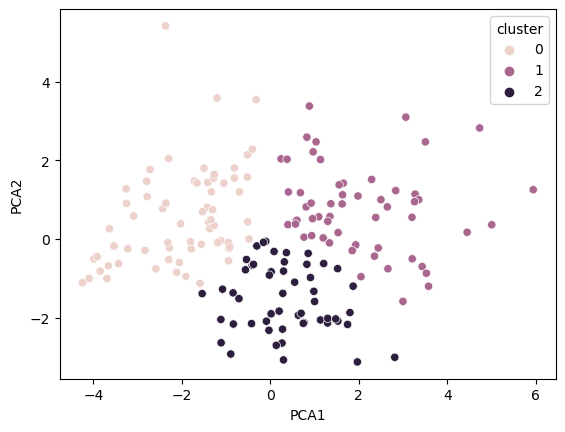

In [10]:
# Plot the clusters with PCA1 and PCA2
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df)

# Exploring Each Cluster
Using PCA for k-means clustering can make interpreting the reasons for grouping or distinguishing the clusters difficult. By incorporating the cluster labels into the original dataset, we can now group the data by each cluster, enabling us to conduct statistical analysis and visualize each group to identify the underlying differences.

In [11]:
# Group the data by cluster and calculate the mean of each feature
clusters = df.groupby('cluster').mean().sort_values(by='cluster')
clusters = clusters.iloc[:,4:24]

### Demographics & Patronage

Cluster 0:

- Average age: 37.44 years
- Proportion of female respondents: 24.37%
- Average income: $35,751.90
- Measure of patronage: 18.49%

Cluster 1:

- Average age: 47.03 years
- Proportion of female respondents: 33.00%
- Average income: $50,313.46
- Measure of patronage: 60.00%

Cluster 2:

- Average age: 36.73 years
- Proportion of female respondents: 5.32%
- Average income: $38,148.80
- Measure of patronage: 46.81%

Cluster 1 has the highest average age, the highest proportion of female respondents, and the highest average income and patronage among the three clusters. Cluster 0 has the lowest proportion of female respondents and the lowest patronage, while Cluster 2 has the lowest average age and the second-lowest average income.

Another thing to note is that the number of male respondents much greater across all clusters. This may introduce some male bias in the results.


In [12]:
# Analyze the demographics and patronage of clusters 
clusters[['age','female','income','patronage']]

,age,female,income,patronage
cluster,,,,
0,37.436975,0.243697,35751.899160,0.184874
1,47.030000,0.330000,50313.460000,0.600000
2,36.734043,0.053191,38148.797872,0.468085


Text(0.5, 1.0, 'Average Age by Cluster')

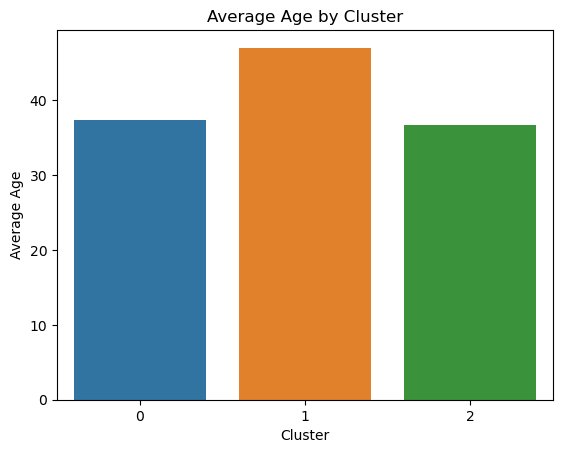

In [13]:
# Create a bar graph of the Age column in the clusters dataframe
sns.barplot(x='cluster', y='age', ci = None, data=df)
# Customize the plot
plt.xlabel('Cluster')
plt.ylabel('Average Age')
plt.title('Average Age by Cluster')

Text(0.5, 1.0, 'Average Income by Cluster')

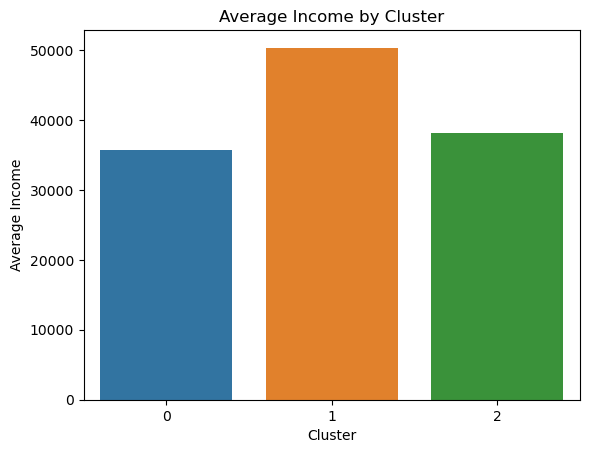

In [14]:
# Create a bar graph of the Income column in the clusters dataframe
sns.barplot(x='cluster', y='income', ci = None, data=df)
# Customize the plot 
plt.xlabel('Cluster')
plt.ylabel('Average Income')
plt.title('Average Income by Cluster')

Text(0.5, 1.0, 'Gender Counts in Each Cluster')

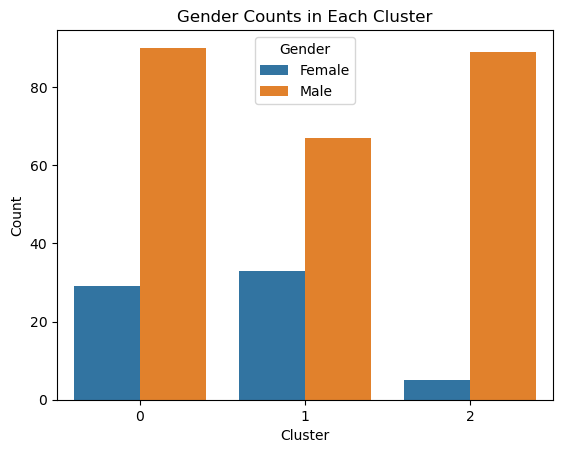

In [15]:
# Create Gender column in the clusters dataframe from female dummy variable
df['Gender'] = df['female'].apply(lambda x: 'Female' if x == 1 else 'Male')

# Analyze the the restaurant preference of clusters
gender_counts = df.groupby('cluster')['Gender'].value_counts().unstack()
# Reset the index to make 'cluster_label' a column
gender_counts = gender_counts.reset_index()
# Convert the DataFrame to long-form format
long_form_df = gender_counts.melt(id_vars='cluster', var_name='Gender', value_name='count')
# Create a bar plot using seaborn
sns.barplot(x='cluster', y='count', hue='Gender', ci = None, data=long_form_df)
# Customize the plot
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender Counts in Each Cluster')

### Important Qualities when Choosing a Restaurant

Cluster 0:

- Convenience: 4.72 
- Variety: 4.60 
- Price: 4.87 
- Healthiness: 4.77 
- Taste: 4.95 

Cluster 1:

- Convenience: 4.09 
- Variety: 3.86 
- Price: 4.28 
- Healthiness: 4.08 
- Taste: 4.84 

Cluster 2:

- Convenience: 4.64 
- Variety: 4.38 
- Price: 4.83 
- Healthiness: 4.76 
- Taste: 5.00 

The respondents in Cluster 2 place the highest value on taste, while the respondents in Cluster 1 place the lowest value on convenience and variety. The respondents in all three clusters place a similar level of importance on price and healthiness.

In [16]:
# Analyze the the restaurant preference of clusters
clusters.iloc[:,1:6]

,importantconvenience,importantvariety,importantprice,importanthealthy,importanttaste
cluster,,,,,
0,4.722689,4.596639,4.873950,4.773109,4.94958
1,4.090000,3.860000,4.280000,4.080000,4.84000
2,4.638298,4.382979,4.829787,4.755319,5.00000


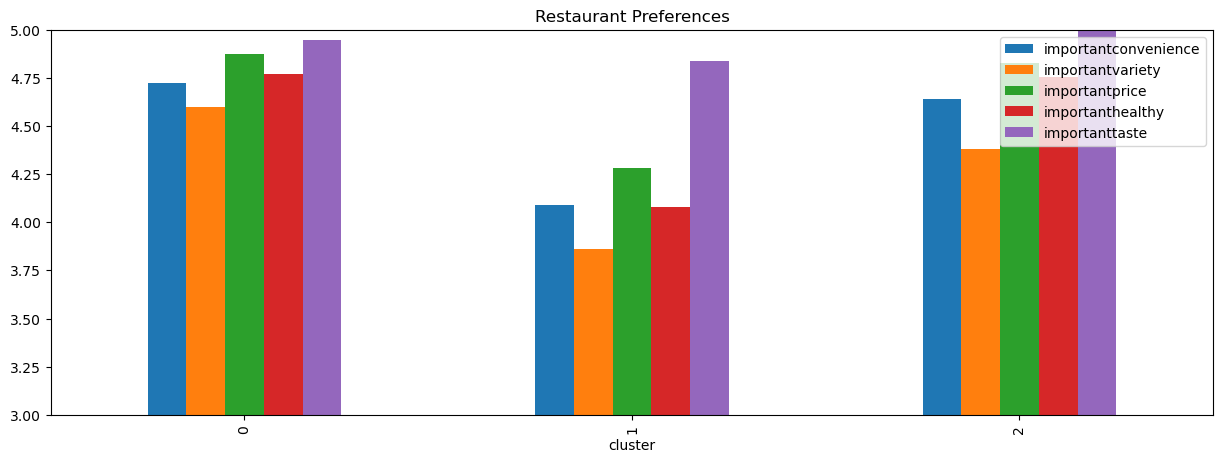

In [17]:
# Create a bar graph of the restaurant preferences in the clusters dataframe
clusters.iloc[:,1:6].plot(kind='bar', figsize=(15,5), title='Restaurant Preferences')
plt.ylim(3, 5)

plt.legend( loc='upper right')


### Rating Performance of Chipotle Experiences

Cluster 0:

- Convenient: 4.50 
- Variety: 4.53
- Price: 4.39 
- Healthiness: 4.90 
- Taste: 4.92 
- Ambience: 4.55 

Cluster 1:

- Convenient: 3.47 
- Variety: 3.36 
- Price: 3.01 
- Healthiness: 4.19 
- Taste: 4.15 
- Ambience: 3.26 

Cluster 2:

- Convenient: 3.24 
- Variety: 3.41 
- Price: 3.15 
- Healthiness: 4.19 
- Taste: 3.89 
- Ambience: 3.32 

Based on the data, it can be seen that the respondents in Cluster 0 had the highest opinions of Chipotle, while the respondents in Cluster 1 had the lowest opinions. The respondents in Cluster 2 had opinions that were somewhere in between the other two clusters.

In [18]:
# Analyze the Chipotle experience of clusters
clusters.iloc[:,7:13]

,chipotleconvenient,chipotlevariety,chipotleprice,chipotlehealthy,chipotletaste,chipotleambience
cluster,,,,,,
0,4.504202,4.529412,4.394958,4.899160,4.924370,4.546218
1,3.470000,3.360000,3.010000,4.190000,4.150000,3.260000
2,3.244681,3.414894,3.148936,4.191489,3.893617,3.319149


(2.5, 5.0)

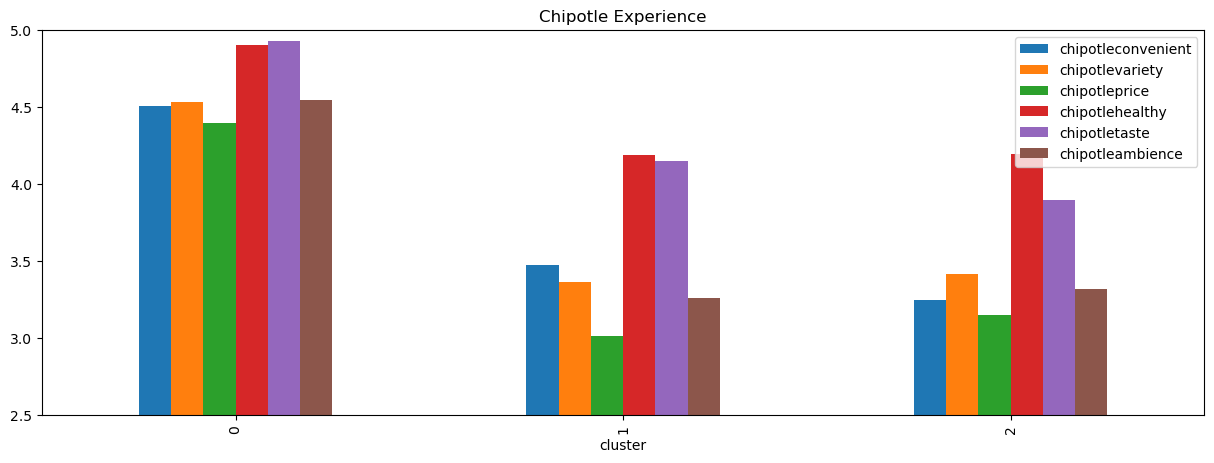

In [19]:
# Create a bar graph of the Chipotle experience in the clusters dataframe
clusters.iloc[:,7:13].plot(kind='bar', figsize=(15,5), title='Chipotle Experience')
plt.ylim(2.5, 5)

# Conclusion & Recommendations

### Overall Cluster Profiles

***Cluster 0: High Expectations, Low Patronage***
- This cluster appears to consist of respondents who have a high opinion of Chipotle restaurants and hold the highest expectations of their restaurants in general. However, they also have the lowest patronage, which raises concerns about what is preventing them from visiting Chipotle more often. 

***Cluster 1: Moderate Opinion, Less Discerning Diners***
- This cluster consists of respondents who have a moderate opinion of Chipotle restaurants, with lower ratings in terms of convenience, variety, taste, and ambience compared to Cluster 0. They are also the least picky when it comes to what is important to them at a restaurant, which could suggest that they are less discerning diners. However, their higher income and lower percentage of female respondents may require further investigation to determine their dining preferences and behaviors.

***Cluster 2: Picky Eaters, Moderate Opinion***
- This cluster is nearly as picky as Cluster 0 when it comes to what is important to them at a restaurant but has a moderate opinion of Chipotle restaurants, similar to Cluster 1. They also have the lowest percentage of female respondents in comparison to the other two clusters, which could indicate that the preferences and behaviors of male customers need to be further explored. Their average age and income are similar to Cluster 0, suggesting that they may have similar lifestyles and dining preferences, but this would require further investigation.

### Marketing Strategy Recommendations

***Cluster 0: High Expectations, Low Patronage***
- Focus on understanding and addressing their concerns through surveys or focus groups. Offer promotions and loyalty programs to encourage more frequent visits. Emphasize Chipotle's position on quality, sustainability, and food preparation in marketing campaigns to align with their high expectations.

***Cluster 1: Moderate Opinion, Less Discerning Diners***
- Highlight Chipotle's convenience factors, such as online ordering, delivery, and mobile app features. Appeal to their cost-conscious preferences with exclusive deals or coupons. Introduce new, limited-time menu items or promotions to pique their interest. Increase visibility and engagement by collaborating with local businesses or events for special offers or discounts. This can all lead to improving their opinion of Chipotle and increasing their patronage. Leverage marketing campaigns that appeal to higher income, older customers.

***Cluster 2: Picky Eaters, Moderate Opinion***
- Highlight the unique aspects of Chipotle's offerings, such as the use of fresh ingredients or their commitment to sustainability, since Cluster 2 is almost as picky as Cluster 0 when it comes to what is important to them at a restaurant but has a moderate opinion of Chipotle similar to Cluster 1. Explore ways to appeal to male customers, given the lower percentage of female respondents in Cluster 2.




